[Google Colaboratory Variant](https://colab.research.google.com/drive/1pymaadPUhSm0T9N5h44ls-mAcrylfa2F)
## Code Modules & Functions

In [1]:
!pip install --upgrade neural_structured_learning --user

     |████████████████████████████████| 120 kB 2.6 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd,numpy as np
import tensorflow_hub as th,tensorflow as tf
import neural_structured_learning as nsl
import os,pylab as pl
from keras.preprocessing import image as kimage
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True 
fpath='../input/tomato-cultivars/'

Using TensorFlow backend.


In [3]:
def path_to_tensor(img_path,fpath=fpath):
    img=kimage.load_img(fpath+img_path, 
                        target_size=(160,160))
    x=kimage.img_to_array(img)
    return np.expand_dims(x,axis=0)
def paths_to_tensor(img_paths):
    tensor_list=[path_to_tensor(img_path) 
                 for img_path in tqdm(img_paths)]
    return np.vstack(tensor_list)

## Data

In [4]:
names=['Kumato','Beefsteak','Tigerella',
       'Roma','Japanese Black Trifele',
       'Yellow Pear','Sun Gold','Green Zebra',
       'Cherokee Purple','Oxheart','Blue Berries',
       'San Marzano','Banana Legs',
       'German Orange Strawberry','Supersweet 100']
flist=sorted(os.listdir(fpath))
labels=np.array([int(el[:2]) for el in flist],
               dtype='float32')-1
images=np.array(paths_to_tensor(flist),
                dtype='float32')/255
N=labels.shape[0]; n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images,labels=images[shuffle_ids],labels[shuffle_ids]
x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=labels[:n],labels[n:2*n],labels[2*n:]

100%|██████████| 776/776 [00:02<00:00, 265.15it/s]


In [5]:
set(labels)

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0}

In [6]:
pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
              [x_train.dtype,x_valid.dtype,x_test.dtype],
              [y_train.shape,y_valid.shape,y_test.shape],
              [y_train.dtype,y_valid.dtype,y_test.dtype]],               
             columns=['train','valid','test'])

,train,valid,test
0,"(622, 160, 160, 3)","(77, 160, 160, 3)","(77, 160, 160, 3)"
1,float32,float32,float32
2,"(622,)","(77,)","(77,)"
3,float32,float32,float32


Label:  8.0 Cherokee Purple


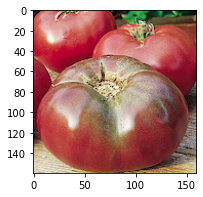

In [7]:
k=np.random.randint(40)
print('Label: ',y_test[k],
      names[int(y_test[k])])
pl.figure(figsize=(3,3))
pl.imshow((x_test[k]));

## NN Examples

In [8]:
fw='weights.best.hdf5'
def premodel(pix,den,mh,lbl,activ,loss):
    model=tf.keras.Sequential([
        tf.keras.layers.Input((pix,pix,3),
                              name='input'),
        th.KerasLayer(mh,trainable=True),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(den,activation='relu'),
        tf.keras.layers.Dropout(rate=.5),
        tf.keras.layers.Dense(lbl,activation=activ)])
    model.compile(optimizer='adam',
                  metrics=['accuracy'],loss=loss)
    display(model.summary())
    return model
def cb(fw):
    early_stopping=tf.keras.callbacks\
    .EarlyStopping(monitor='val_loss',patience=20,verbose=2)
    checkpointer=tf.keras.callbacks\
    .ModelCheckpoint(filepath=fw,save_best_only=True,verbose=2)
    lr_reduction=tf.keras.callbacks\
    .ReduceLROnPlateau(monitor='val_loss',verbose=2,
                       patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [9]:
[handle_base,pixels]=["inception_v3",160]
mhandle="https://tfhub.dev/google/imagenet/{}/classification/4"\
.format(handle_base)

In [10]:
model=premodel(pixels,1024,mhandle,15,
               'softmax','sparse_categorical_crossentropy')
history=model.fit(x=x_train,y=y_train,batch_size=32,
                  epochs=70,callbacks=cb(fw),
                  validation_data=(x_valid,y_valid))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              23853833  
_________________________________________________________________
flatten (Flatten)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1026048   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                15375     
Total params: 24,895,256
Trainable params: 24,860,824
Non-trainable params: 34,432
_________________________________________________________________


None

Epoch 1/70
20/20 [==============================] - ETA: 0s - loss: 3.5874 - accuracy: 0.1527
Epoch 00001: val_loss improved from inf to 424.18121, saving model to weights.best.hdf5
20/20 [==============================] - 6s 282ms/step - loss: 3.5874 - accuracy: 0.1527 - val_loss: 424.1812 - val_accuracy: 0.0519 - lr: 0.0010
Epoch 2/70
20/20 [==============================] - ETA: 0s - loss: 2.8554 - accuracy: 0.2765
Epoch 00002: val_loss improved from 424.18121 to 105.56178, saving model to weights.best.hdf5
20/20 [==============================] - 3s 152ms/step - loss: 2.8554 - accuracy: 0.2765 - val_loss: 105.5618 - val_accuracy: 0.0519 - lr: 0.0010
Epoch 3/70
20/20 [==============================] - ETA: 0s - loss: 2.1695 - accuracy: 0.4566
Epoch 00003: val_loss did not improve from 105.56178
20/20 [==============================] - 2s 96ms/step - loss: 2.1695 - accuracy: 0.4566 - val_loss: 134.5296 - val_accuracy: 0.0909 - lr: 0.0010
Epoch 4/70
20/20 [============================

In [11]:
model.load_weights(fw)
model.evaluate(x_test,y_test)

3/3 [==============================] - 0s 20ms/step - loss: 1.9695 - accuracy: 0.6883


[1.9695203304290771, 0.6883116960525513]

In [12]:
[handle_base,pixels]=["mobilenet_v2_100_160",160]
mhandle="https://tfhub.dev/google/imagenet/{}/classification/4"\
.format(handle_base)

In [13]:
model=premodel(pixels,1024,mhandle,15,
               'softmax','sparse_categorical_crossentropy')
history=model.fit(x=x_train,y=y_train,batch_size=32,
                  epochs=70,callbacks=cb(fw),
                  validation_data=(x_valid,y_valid))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              3540265   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1001)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1026048   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                15375     
Total params: 4,581,688
Trainable params: 4,547,576
Non-trainable params: 34,112
_________________________________________________________________


None

Epoch 1/70
20/20 [==============================] - ETA: 0s - loss: 2.2770 - accuracy: 0.4164
Epoch 00001: val_loss improved from inf to 9.88961, saving model to weights.best.hdf5
20/20 [==============================] - 3s 172ms/step - loss: 2.2770 - accuracy: 0.4164 - val_loss: 9.8896 - val_accuracy: 0.3117 - lr: 0.0010
Epoch 2/70
20/20 [==============================] - ETA: 0s - loss: 1.1169 - accuracy: 0.7170
Epoch 00002: val_loss did not improve from 9.88961
20/20 [==============================] - 2s 88ms/step - loss: 1.1169 - accuracy: 0.7170 - val_loss: 12.4484 - val_accuracy: 0.2727 - lr: 0.0010
Epoch 3/70
19/20 [===========================>..] - ETA: 0s - loss: 1.0816 - accuracy: 0.7516
Epoch 00003: val_loss did not improve from 9.88961
20/20 [==============================] - 2s 87ms/step - loss: 1.0799 - accuracy: 0.7492 - val_loss: 11.7061 - val_accuracy: 0.3247 - lr: 0.0010
Epoch 4/70
19/20 [===========================>..] - ETA: 0s - loss: 0.7968 - accuracy: 0.8405
Epoc

In [14]:
model.load_weights(fw)
model.evaluate(x_test,y_test)

3/3 [==============================] - 0s 9ms/step - loss: 1.5742 - accuracy: 0.7273


[1.5742274522781372, 0.7272727489471436]

In [15]:
batch_size=64; img_size=x_train.shape[1]; epochs=30
base_model=tf.keras.Sequential([
    tf.keras.Input((img_size,img_size,3),name='input'),
    tf.keras.layers.Conv2D(32,(5,5),padding='same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Conv2D(196,(5,5)),
    tf.keras.layers.Activation('relu'),    
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.GlobalMaxPooling2D(),    
    tf.keras.layers.Dense(512),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(15,activation='softmax')
])
adv_config=nsl.configs\
.make_adv_reg_config(multiplier=.2,adv_step_size=.05)
adv_model=nsl.keras\
.AdversarialRegularization(base_model,adv_config=adv_config)
adv_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [16]:
train=tf.data.Dataset.from_tensor_slices(
    {'input':x_train,'label':y_train})\
     .batch(batch_size)
valid=tf.data.Dataset.from_tensor_slices(
    {'input':x_valid,'label':y_valid})\
     .batch(batch_size)
valid_steps=x_valid.shape[0]//batch_size
adv_model.fit(train,validation_data=valid,verbose=2,
              validation_steps=valid_steps,epochs=epochs)

Epoch 1/30
10/10 - 2s - loss: 3.2608 - sparse_categorical_crossentropy: 2.7150 - sparse_categorical_accuracy: 0.0836 - scaled_adversarial_loss: 0.5458 - val_loss: 3.2250 - val_sparse_categorical_crossentropy: 2.6871 - val_sparse_categorical_accuracy: 0.0625 - val_scaled_adversarial_loss: 0.5379
Epoch 2/30
10/10 - 1s - loss: 3.1183 - sparse_categorical_crossentropy: 2.5997 - sparse_categorical_accuracy: 0.1592 - scaled_adversarial_loss: 0.5186 - val_loss: 3.0784 - val_sparse_categorical_crossentropy: 2.5648 - val_sparse_categorical_accuracy: 0.1250 - val_scaled_adversarial_loss: 0.5136
Epoch 3/30
10/10 - 1s - loss: 2.8154 - sparse_categorical_crossentropy: 2.3458 - sparse_categorical_accuracy: 0.1945 - scaled_adversarial_loss: 0.4696 - val_loss: 2.7053 - val_sparse_categorical_crossentropy: 2.2531 - val_sparse_categorical_accuracy: 0.2500 - val_scaled_adversarial_loss: 0.4522
Epoch 4/30
10/10 - 1s - loss: 2.5396 - sparse_categorical_crossentropy: 2.1174 - sparse_categorical_accuracy: 0.

In [17]:
adv_model.evaluate({'input':x_test,'label':y_test})

3/3 [==============================] - 0s 42ms/step - loss: 1.8773 - sparse_categorical_crossentropy: 1.5571 - sparse_categorical_accuracy: 0.4416 - scaled_adversarial_loss: 0.3202


[1.8772954940795898,
 1.5570834875106812,
 0.44155845046043396,
 0.3202119767665863]